In [1]:
import bacco
import numpy as np
import matplotlib.pyplot as plt
import pickle5 as pickle
bacco.plotting.set_defaults(useTex=False)

0

# readgadget

In [2]:
# This library is designed to read Gadget format I, format II and hdf5 files
import numpy as np
import readsnap
import sys,os,h5py,hdf5plugin

# find snapshot name and format
def fname_format(snapshot):
    if os.path.exists(snapshot):
        if snapshot[-4:]=='hdf5':  filename, fformat = snapshot, 'hdf5'
        else:                      filename, fformat = snapshot, 'binary'
    elif os.path.exists(snapshot+'.0'):
        filename, fformat = snapshot+'.0', 'binary'
    elif os.path.exists(snapshot+'.hdf5'):
        filename, fformat = snapshot+'.hdf5', 'hdf5'
    elif os.path.exists(snapshot+'.0.hdf5'):
        filename, fformat = snapshot+'.0.hdf5', 'hdf5'
    else:  raise Exception('File not found!')
    return filename,fformat


# This class reads the header of the gadget file
class header:
    def __init__(self, snapshot):

        filename, fformat = fname_format(snapshot)

        if fformat=='hdf5':
            f             = h5py.File(filename, 'r')
            
            self.time     = f['Header'].attrs[u'Time']
            self.redshift = f['Header'].attrs[u'Redshift']
            self.npart    = (f['Header'].attrs[u'NumPart_ThisFile']).astype(np.int64)
            self.nall     = (f['Header'].attrs[u'NumPart_Total']).astype(np.int64)
            self.filenum  = int(f['Header'].attrs[u'NumFilesPerSnapshot'])
            self.massarr  = f['Header'].attrs[u'MassTable']
            self.boxsize  = f['Header'].attrs[u'BoxSize']

            # check if it is a SWIFT snapshot
            if '/Cosmology' in f.keys():
                self.omega_m  = f['Cosmology'].attrs[u'Omega_m']
                self.omega_l  = f['Cosmology'].attrs[u'Omega_lambda']
                self.hubble   = f['Cosmology'].attrs[u'h']

            # check if it is a Gadget-4 snapshot
            elif '/Parameters' in f.keys():
                self.omega_m  = f['Parameters'].attrs[u'Omega0']
                self.omega_l  = f['Parameters'].attrs[u'OmegaLambda']
                self.hubble   = f['Parameters'].attrs[u'HubbleParam']
                #self.cooling  = f['Parameters'].attrs[u'Flag_Cooling']

            # if it is a traditional Gadget-1/2/3 snapshot
            else:
                self.omega_m  = f['Header'].attrs[u'Omega0']
                self.omega_l  = f['Header'].attrs[u'OmegaLambda']
                self.hubble   = f['Header'].attrs[u'HubbleParam']
                #self.cooling  = f['Header'].attrs[u'Flag_Cooling']

            self.format   = 'hdf5'
            f.close()

        else:        
            head = readsnap.snapshot_header(filename)
            self.time     = head.time
            self.redshift = head.redshift
            self.boxsize  = head.boxsize
            self.filenum  = head.filenum
            self.omega_m  = head.omega_m
            self.omega_l  = head.omega_l
            self.hubble   = head.hubble
            self.massarr  = head.massarr
            self.npart    = head.npart
            self.nall     = head.nall
            self.cooling  = head.cooling
            self.format   = head.format

        # km/s/(Mpc/h)
        self.Hubble = 100.0*np.sqrt(self.omega_m*(1.0+self.redshift)**3+self.omega_l)


# This function reads a block of an individual file of a gadget snapshot
def read_field(snapshot, block, ptype):

    filename, fformat = fname_format(snapshot)
    head              = header(filename)
    Masses            = head.massarr*1e10 #Msun/h                  
    Npart             = head.npart        #number of particles in the subfile
    Nall              = head.nall         #total number of particles in the snapshot
    
    if fformat=="binary":
        return readsnap.read_block(filename, block, parttype=ptype)
    else:
        prefix = 'PartType%d/'%ptype
        f = h5py.File(filename, 'r')
        if   block=="POS ":  suffix = "Coordinates"
        elif block=="MASS":  suffix = "Masses"
        elif block=="ID  ":  suffix = "ParticleIDs"
        elif block=="VEL ":  suffix = "Velocities"
        else: raise Exception('block not implemented in readgadget!')

        if '%s%s'%(prefix,suffix) not in f.keys():
            if Masses[ptype] != 0.0:
                array = np.ones(Npart[ptype], np.float32)*Masses[ptype]
            else:
                raise Exception('Problem reading the block %s'%block)
        else:
            array = f[prefix+suffix][:]
        f.close()

        if block=="VEL ":  array *= np.sqrt(head.time)
        if block=="POS " and array.dtype==np.float64:
            array = array.astype(np.float32)

        return array

# This function reads a block from an entire gadget snapshot (all files)
# it can read several particle types at the same time. 
# ptype has to be a list. E.g. ptype=[1], ptype=[1,2], ptype=[0,1,2,3,4,5]
def read_block(snapshot, block, ptype, verbose=False):

    # find the format of the file and read header
    filename, fformat = fname_format(snapshot)
    head    = header(filename)    
    Nall    = head.nall
    filenum = head.filenum

    # find the total number of particles to read
    Ntotal = 0
    for i in ptype:
        Ntotal += Nall[i]

    # find the dtype of the block
    if   block=="POS ":  dtype=np.dtype((np.float32,3))
    elif block=="VEL ":  dtype=np.dtype((np.float32,3))
    elif block=="MASS":  dtype=np.float32
    elif block=="ID  ":  dtype=read_field(filename, block, ptype[0]).dtype
    else: raise Exception('block not implemented in readgadget!')

    # define the array containing the data
    array = np.zeros(Ntotal, dtype=dtype)


    # do a loop over the different particle types
    offset = 0
    for pt in ptype:

        # format I or format II Gadget files
        if fformat=="binary":
            array[offset:offset+Nall[pt]] = \
                readsnap.read_block(snapshot, block, pt, verbose=verbose)
            offset += Nall[pt]

        # single files (either binary or hdf5)
        elif filenum==1:
            array[offset:offset+Nall[pt]] = read_field(snapshot, block, pt)
            offset += Nall[pt]

        # multi-file hdf5 snapshot
        else:

            # do a loop over the different files
            for i in range(filenum):
                
                # find the name of the file to read
                filename = '%s.%d.hdf5'%(snapshot,i)

                # read number of particles in the file and read the data
                npart = header(filename).npart[pt]
                array[offset:offset+npart] = read_field(filename, block, pt)
                offset += npart   

    if offset!=Ntotal:  raise Exception('not all particles read!!!!')
            
    return array

# Loading Quijote

In [188]:
qsim, ngrid = "663", 512

qsim, ngrid = "663_HR", 1024

sim_ICs = bacco.Simulation(basedir="/dipc/reangulo/tmp/{0}/ICs/".format(qsim), 
                       dm_file="ics", sim_format="gadget_hdf5", phase=0.00, fixedPk=False, UnitLength_in_cm=3.085678e+21,
                       ns=0.960700, sigma8=0.831100, seed=663, hubble=0.701500, omega_baryon=0.046250, tau=0.0952, timebegin=0.0078125)

sim = bacco.Simulation(basedir="/dipc/reangulo/tmp/{0}/".format(qsim), 
                       dm_file="snapdir_004/snap_004", sim_format="gadget_hdf5", phase=0.00, fixedPk=False, UnitLength_in_cm=3.085678e+21,
                       ns=0.960700, sigma8=0.831100, seed=663, hubble=0.701500, omega_baryon=0.046250, tau=0.0952, timebegin=0.0078125)
#sim.dm['pos'] = sim.dm['pos']/1000
index_neigh = sim.dm['ids']-1
pksim = sim.get_Power(kmin=0.01, kmax=1, nbins=50, log_binning=True, deposit_method='cic')


2024-08-14 15:03:29,800 bacco.sims : Initialising simulation Default
2024-08-14 15:03:29,800 bacco.sims : try /dipc/reangulo/tmp/663_HR/ICs/ics
2024-08-14 15:03:29,803 bacco.sims : Loading /dipc/reangulo/tmp/663_HR/ICs/ics
2024-08-14 15:03:29,806 bacco.cosmo :    initialization took 0.000 secs
2024-08-14 15:03:30,468 bacco.sims : ...done in 0.00656 s
Exception ignored in: <function Simulation.__del__ at 0x2b4183b74430>
Traceback (most recent call last):
  File "/scratch/reangulo/work_edr/baccogit/bacco/simulation.py", line 596, in __del__
    self.cleanup()
  File "/scratch/reangulo/work_edr/baccogit/bacco/simulation.py", line 10658, in cleanup
    self.Cosmology.cleanup()
AttributeError: 'Simulation' object has no attribute 'Cosmology'
2024-08-14 15:03:31,012 bacco.sims : Initialising simulation Default
2024-08-14 15:03:31,012 bacco.sims : try /dipc/reangulo/tmp/663_HR/snapdir_004/snap_004
2024-08-14 15:03:31,015 bacco.sims : Loading /dipc/reangulo/tmp/663_HR/snapdir_004/snap_004
2024

/dipc/reangulo/tmp/663_HR/snapdir_004/snap_004.0.hdf5


2024-08-14 15:03:38,963 bacco.sims : Read data for 136100136/1073741824 particles...
2024-08-14 15:03:38,968 bacco.sims : Read data for 134427762/1073741824 particles...
2024-08-14 15:03:46,521 bacco.sims : Read data for 134427762/1073741824 particles...
2024-08-14 15:03:46,525 bacco.sims : Read data for 133741847/1073741824 particles...
2024-08-14 15:03:53,968 bacco.sims : Read data for 133741847/1073741824 particles...
2024-08-14 15:03:53,972 bacco.sims : Read data for 133629286/1073741824 particles...
2024-08-14 15:04:01,279 bacco.sims : Read data for 133629286/1073741824 particles...
2024-08-14 15:04:01,283 bacco.sims : Read data for 133519677/1073741824 particles...
2024-08-14 15:04:08,567 bacco.sims : Read data for 133519677/1073741824 particles...
2024-08-14 15:04:08,571 bacco.sims : Read data for 133635908/1073741824 particles...
2024-08-14 15:04:16,148 bacco.sims : Read data for 133635908/1073741824 particles...
2024-08-14 15:04:16,153 bacco.sims : Read data for 133958794/1073

In [58]:
64**2

4096

In [4]:
q = bacco.visualization.uniform_grid(npix=ngrid, L=1000, ndim=3, bounds=False)
disp = np.load("/cosmos_storage/home/mpelle/Yin_data/Quijote/LH0663/dis_0663.npy")
displ = np.zeros_like(q)
displ[:,:,:,0] = disp[0]
displ[:,:,:,1] = disp[1]
displ[:,:,:,2] = disp[2]

pp = (q + displ + 1000) % 1000
pp = pp.reshape(512**3,3)


## Validating the stored displacement fields

In [193]:
snapnum = 4
ptype   = [1] 
BoxSize = 1000
root    = "/dipc/reangulo/tmp/"
ICs_snapshot = '%s/%s/ICs/ics'%(root,qsim)
snapshot     = '%s/%s/snapdir_%03d/snap_%03d'%(root,qsim,snapnum,snapnum)

# read the positions and IDs of the ICs
pos_ICs = read_block(ICs_snapshot, "POS ", ptype)/1e3 #Mpc/h
IDs_ICs = read_block(ICs_snapshot, "ID  ", ptype)-1   #IDs begin from 0

# sort the ICs particles by IDs
indexes = np.argsort(IDs_ICs)
pos_ICs = pos_ICs[indexes]; 
#del IDs_ICs

# read the positions and IDs of the z=0 snapshot
pos = read_block(snapshot, "POS ", ptype)/1e3 #Mpc/h
IDs = read_block(snapshot, "ID  ", ptype)-1   #Make IDs begin from 0


#del IDs


In [ ]:
sim.header

In [200]:
# find the grid coordinates of the particles
grid_index = (np.round((pos_ICs/1e3/BoxSize)*ngrid, decimals=0)).astype(np.int32)
grid_index[np.where(grid_index==ngrid)]=0
pos_lag    = grid_index*BoxSize/ngrid #get the lagrangian coordinates
grid_index = grid_index[:,0]*ngrid**2 + grid_index[:,1]*ngrid + grid_index[:,2]
indexes2   = np.argsort(grid_index)
# sort the particles by IDs
indexes = np.argsort(IDs)
lag_index = indexes[indexes2]

# safety check
grid_index = grid_index[indexes2]
diff = grid_index[1:] - grid_index[:-1]
if np.any(diff!=1):  raise Exception('positions not properly sorted')

#Saving indexes 

with open("quijote_{0}_neighfile.pickle".format(qsim), 'wb') as f:
    pickle.dump(lag_index, f, protocol=-1)
    
# More checks
pos     = pos[indexes];  
pos_lag = pos_ICs[indexes2];  

# compute displacement field
qdisp = pos - pos_ICs;  

# take into account periodic boundary conditions
qdisp[np.where(qdisp>BoxSize/2.0)]  -= BoxSize
qdisp[np.where(qdisp<-BoxSize/2.0)] += BoxSize
qdisp = qdisp[indexes2]


dx = sim.dm['pos'][lag_index]-pp
dx[np.where(dx>BoxSize/2.0)]  -= BoxSize
dx[np.where(dx<-BoxSize/2.0)] += BoxSize

print("Maximum difference between Eulerian positions: {0} {0}".format(np.min(dx), np.max(dx)))


Exception: positions not properly sorted

## Need to figure out why this doesn't work

In [49]:
IDs_ICs = read_block(ICs_snapshot, "ID  ", ptype)-1   #IDs begin from 0

In [68]:
_qq.shape

(64, 64, 64, 3)

In [103]:
_qq = bacco.visualization.uniform_grid(npix=64, L=125, ndim=3, bounds=False)
subbox = 125.
qx = _qq[...,0].flatten() 
qy = _qq[...,1].flatten() 
qz = _qq[...,2].flatten() 
_ids = np.arange(64**3)

qq = []
ii = 0
glassfactor = 8
for i in range(glassfactor):
    for j in range(glassfactor):
        for k in range(glassfactor):
            _qqx = np.array([qx + i*subbox, qy + j*subbox, qz + k*subbox])
            if ii == 0:
                qq = _qqx
                ids = _ids
            else:
                qq = np.hstack((qq,_qqx))
                ids = np.hstack((ids,_ids+ii*64**3))
            print(np.shape(qq))
            ii+=1


(3, 262144)
(3, 524288)
(3, 786432)
(3, 1048576)
(3, 1310720)
(3, 1572864)
(3, 1835008)
(3, 2097152)
(3, 2359296)
(3, 2621440)
(3, 2883584)
(3, 3145728)
(3, 3407872)
(3, 3670016)
(3, 3932160)
(3, 4194304)
(3, 4456448)
(3, 4718592)
(3, 4980736)
(3, 5242880)
(3, 5505024)
(3, 5767168)
(3, 6029312)
(3, 6291456)
(3, 6553600)
(3, 6815744)
(3, 7077888)
(3, 7340032)
(3, 7602176)
(3, 7864320)
(3, 8126464)
(3, 8388608)
(3, 8650752)
(3, 8912896)
(3, 9175040)
(3, 9437184)
(3, 9699328)
(3, 9961472)
(3, 10223616)
(3, 10485760)
(3, 10747904)
(3, 11010048)
(3, 11272192)
(3, 11534336)
(3, 11796480)
(3, 12058624)
(3, 12320768)
(3, 12582912)
(3, 12845056)
(3, 13107200)
(3, 13369344)
(3, 13631488)
(3, 13893632)
(3, 14155776)
(3, 14417920)
(3, 14680064)
(3, 14942208)
(3, 15204352)
(3, 15466496)
(3, 15728640)
(3, 15990784)
(3, 16252928)
(3, 16515072)
(3, 16777216)
(3, 17039360)
(3, 17301504)
(3, 17563648)
(3, 17825792)
(3, 18087936)
(3, 18350080)
(3, 18612224)
(3, 18874368)
(3, 19136512)
(3, 19398656)
(3, 1

In [141]:
# find the grid coordinates of the particles
grid_index = (np.round((qq.T/BoxSize)*grid, decimals=0)).astype(np.int32)
grid_index[np.where(grid_index==grid)]=0
grid_index = grid_index[:,0]*grid**2 + grid_index[:,1]*grid + grid_index[:,2]
indexes2   = np.argsort(grid_index)

# sort the particles by IDs
indexes = np.argsort(sim.dm['ids'])
lag_index2 = indexes[indexes2]


In [153]:
dx = qq[:,indexes2]-pos_lag.T
dx[np.where(dx>BoxSize/2.0)]  -= BoxSize
dx[np.where(dx<-BoxSize/2.0)] += BoxSize

(array([1.5790000e+03, 9.2011000e+04, 2.0360500e+06, 1.6201001e+07,
        4.5979010e+07, 4.8558392e+07, 1.8643403e+07, 2.5717000e+06,
        1.3336200e+05, 1.2200000e+03]),
 array([-0.29376221, -0.23556519, -0.17736816, -0.11917114, -0.06097412,
        -0.0027771 ,  0.05541992,  0.11361694,  0.17181396,  0.23001099,
         0.28820801]),
 <BarContainer object of 10 artists>)

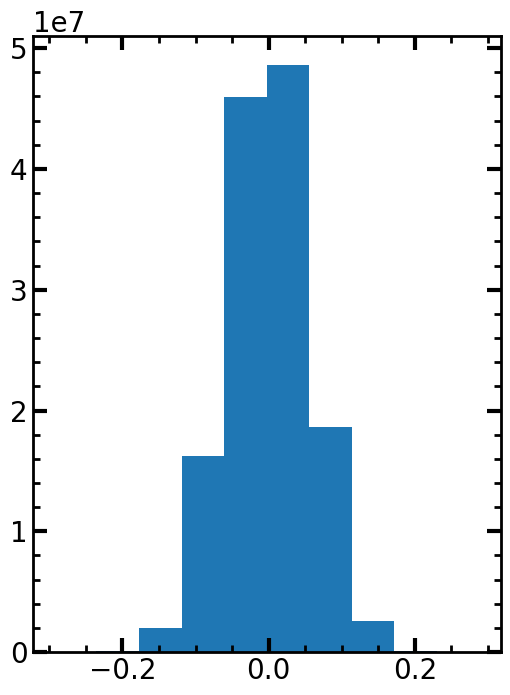

In [161]:
plt.hist(dx[2,:])

In [162]:
qq

array([[  0.      ,   0.      ,   0.      , ..., 998.0469  , 998.0469  ,
        998.0469  ],
       [  0.      ,   0.      ,   0.      , ..., 998.0469  , 998.0469  ,
        998.0469  ],
       [  0.      ,   1.953125,   3.90625 , ..., 994.1406  , 996.09375 ,
        998.0469  ]], dtype=float32)

In [158]:
dx.shape

(3, 134217728)

In [144]:
print(np.max(np.abs(lag_index2-lag_index)))
i0,i1=4050,4150
print(lag_index[i0:i1])
print(lag_index2[i0:i1])

0
[1835474 1835475 1835476 1835477 1835478 1835479 1835480 1835481 1835482
 1835483 1835484 1835485 1835486 1835487 1835488 1835489 1835490 1835491
 1835492 1835493 1835494 1835495 1835496 1835497 1835498 1835499 1835500
 1835501 1835502 1835503 1835504 1835505 1835506 1835507 1835508 1835509
 1835510 1835511 1835512 1835513 1835514 1835515 1835516 1835517 1835518
 1835519     512     513     514     515     516     517     518     519
     520     521     522     523     524     525     526     527     528
     529     530     531     532     533     534     535     536     537
     538     539     540     541     542     543     544     545     546
     547     548     549     550     551     552     553     554     555
     556     557     558     559     560     561     562     563     564
     565]
[1835474 1835475 1835476 1835477 1835478 1835479 1835480 1835481 1835482
 1835483 1835484 1835485 1835486 1835487 1835488 1835489 1835490 1835491
 1835492 1835493 1835494 1835495 183549

In [129]:
IDs-sim.dm['ids']

array([-1, -1, -1, ..., -1, -1, -1])

array([400, 401, 402, 403, 404, 405, 406, 407, 408, 409])

In [134]:
lag_index[400:410]

array([1572880, 1572881, 1572882, 1572883, 1572884, 1572885, 1572886,
       1572887, 1572888, 1572889])

In [118]:
print(np.min(lag_index2-lag_index))

0


In [53]:
print(IDs_ICs[4050:4150])
print(grid_index[4050:4150])

[  4050   4051   4052   4053   4054   4055   4056   4057   4058   4059
   4060   4061   4062   4063   4064   4065   4066   4067   4068   4069
   4070   4071   4072   4073   4074   4075   4076   4077   4078   4079
   4080   4081   4082   4083   4084   4085   4086   4087   4088   4089
   4090   4091   4092   4093   4094   4095 262144 262145 262146 262147
 262148 262149 262150 262151 262152 262153 262154 262155 262156 262157
 262158 262159 262160 262161 262162 262163 262164 262165 262166 262167
 262168 262169 262170 262171 262172 262173 262174 262175 262176 262177
 262178 262179 262180 262181 262182 262183 262184 262185 262186 262187
 262188 262189 262190 262191 262192 262193 262194 262195 262196 262197]
[4050 4051 4052 4053 4054 4055 4056 4057 4058 4059 4060 4061 4062 4063
 4064 4065 4066 4067 4068 4069 4070 4071 4072 4073 4074 4075 4076 4077
 4078 4079 4080 4081 4082 4083 4084 4085 4086 4087 4088 4089 4090 4091
 4092 4093 4094 4095 4096 4097 4098 4099 4100 4101 4102 4103 4104 4105
 4106

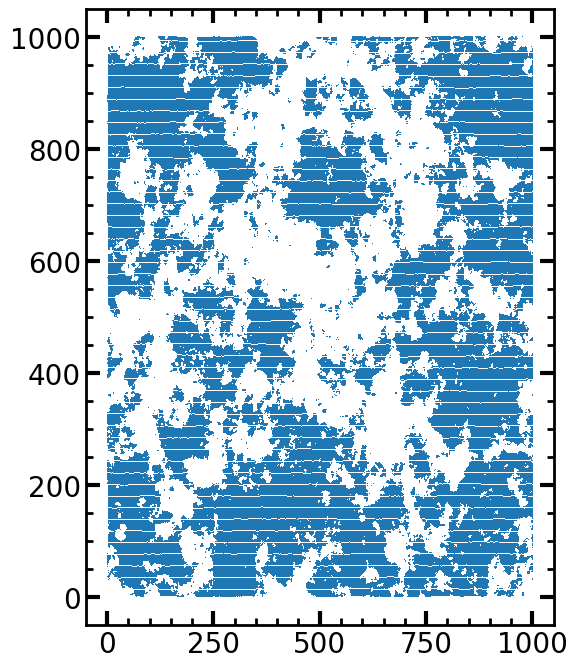

In [56]:
mask = pos_ICs[:,2] < 1
plt.plot(pos_ICs[mask,0], pos_ICs[mask,1],',')

In [51]:
neq = np.where( (grid_index[:10000]-IDs_ICs[:10000]) == 0)[0]
print("number of equals: {0} of {1}".format(len(neq), 512**3))

number of equals: 4096 of 134217728


In [ ]:
ngrid = 600
ids = sim.dm['ids'] - 1
qq = np.zeros(ids.shape + (3,), dtype=np.float32)

qq[..., 0] = ids // ngrid**2
qq[..., 1] = (ids // ngrid) % ngrid
qq[..., 2] = ids % ngrid
qq = qq * (sim.header['BoxSize']/ngrid)

In [70]:
qdisp

array([[-3.0374146 ,  1.5611234 , -3.1153564 ],
       [-3.194336  ,  1.5179172 , -5.0926514 ],
       [-2.3466797 ,  1.0554459 , -7.0186768 ],
       ...,
       [ 0.03173828, -0.29437256, -3.7548218 ],
       [-0.3324585 , -0.67767334, -6.192688  ],
       [-0.65753174,  1.6317139 , -4.8081055 ]], dtype=float32)

In [71]:
disp[0,...]

array([[[-3.0755615 , -3.2235107 , -2.3686523 , ..., -1.9675903 ,
         -2.4111328 , -2.6365967 ],
        [-2.9282227 , -3.2504883 , -3.1639404 , ..., -3.8048706 ,
         -3.5530396 , -3.8181152 ],
        [-4.1376343 , -4.182312  , -3.2202148 , ..., -5.6550903 ,
         -5.579956  , -4.920471  ],
        ...,
        [-1.9995117 , -2.192627  , -1.8391113 , ..., -2.0495605 ,
         -2.284668  , -2.1079102 ],
        [-1.2908325 , -1.541626  , -1.944397  , ..., -2.0964355 ,
         -2.157959  , -2.048767  ],
        [-2.1992188 , -2.0715942 , -2.1852417 , ..., -1.961731  ,
         -2.3862915 , -1.5228882 ]],

       [[-4.6290283 , -4.572571  , -4.6013184 , ..., -3.824707  ,
         -4.236328  , -3.3980713 ],
        [-3.0847168 , -2.9988403 , -2.9579468 , ..., -4.1660156 ,
         -3.6616821 , -3.3239136 ],
        [-3.376587  , -2.9763184 , -3.4088745 , ..., -4.2197876 ,
         -3.4332886 , -2.8952637 ],
        ...,
        [-3.9508057 , -3.9735718 , -3.8983765 , ..., -

In [315]:
# compute displacement field
zdisp = pos_ICs - pos_lag;  del pos_ICs

# take into account periodic boundary conditions
zdisp[np.where(zdisp>BoxSize/2.0)]  -= BoxSize
zdisp[np.where(zdisp<-BoxSize/2.0)] += BoxSize
zdisp = zdisp
zdisp = zdisp[indexes2]


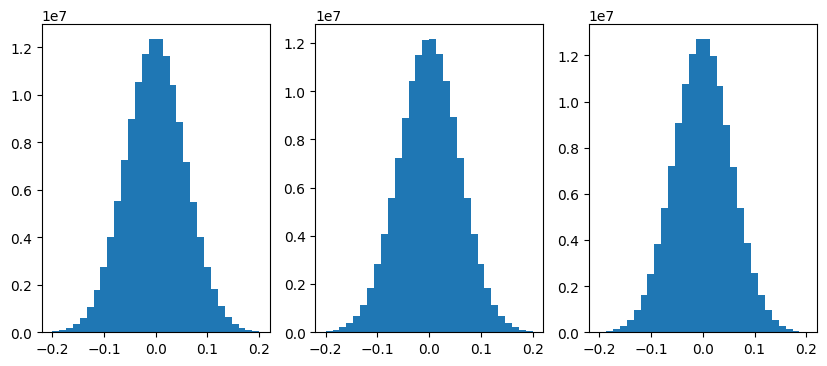

In [319]:
#plt.hist(dx, range=[-100,100],bins=30)
fig, ax = plt.subplots(1,3, figsize=(10,4))
for axis in range(3):
    ax[axis].hist(zdisp[:,axis].flatten(),ls=':',range=[-0.2,0.2], bins=30)
    #ax[axis].hist(disp[axis,...].flatten(),ls=':',range=[-20,20], bins=30)

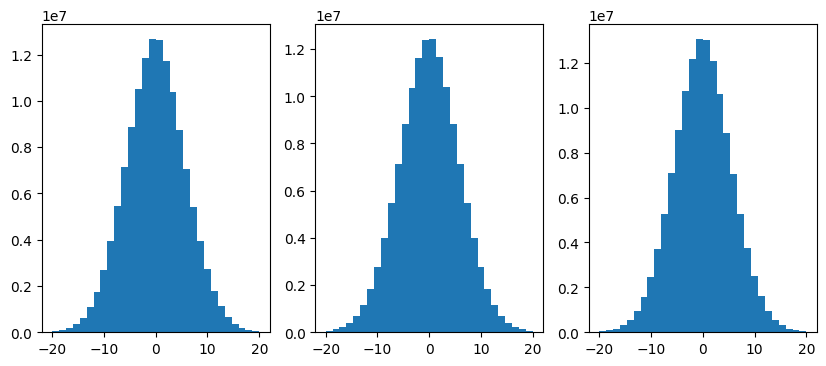

In [310]:
#plt.hist(dx, range=[-100,100],bins=30)
fig, ax = plt.subplots(1,3, figsize=(10,4))
for axis in range(3):
    ax[axis].hist(qdisp[:,axis].flatten(),ls=':',range=[-20,20], bins=30)
    #ax[axis].hist(disp[axis,...].flatten(),ls=':',range=[-20,20], bins=30)

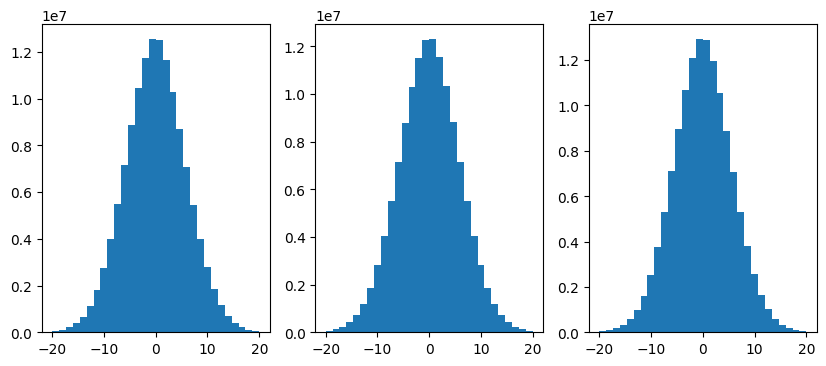

In [307]:
fig, ax = plt.subplots(1,3, figsize=(10,4))
for axis in range(3):
    ax[axis].hist(disp[axis,...].flatten(),ls=':',range=[-20,20], bins=30)

In [9]:
print("min", np.min(index_neigh-sim.dm['ids']+1))
print("max", np.max(index_neigh-sim.dm['ids']+1))

min 0
max 0


(array([13424096., 13412008., 13427713., 13424676., 13419931., 13424348.,
        13415202., 13425804., 13421734., 13422216.]),
 array([-4.99999878e+02, -3.99999878e+02, -2.99999908e+02, -1.99999908e+02,
        -9.99999237e+01,  6.10351562e-05,  1.00000046e+02,  2.00000031e+02,
         3.00000031e+02,  4.00000000e+02,  5.00000000e+02]),
 <BarContainer object of 10 artists>)

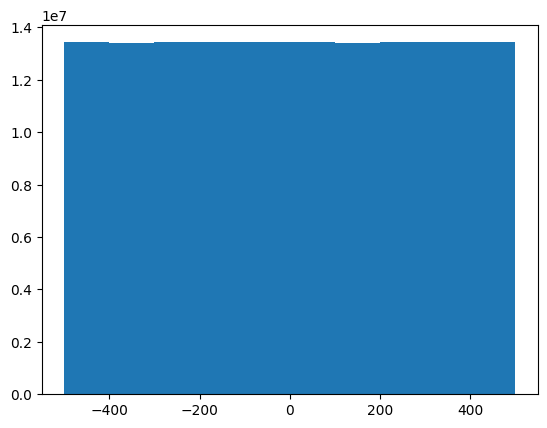

In [93]:
dx = (sim.dm['pos'][:,0]-q[...,0].flatten()[index_neigh] + 2000) % 1000 
dy = (sim.dm['pos'][:,1]-q[...,2].flatten() + 2000) % 1000 
dz = (sim.dm['pos'][:,2]-q[...,2].flatten()[index_neigh] + 2000) % 1000 

dx[dx > 500] -= 1000
dy[dy > 500] -= 1000
dz[dz > 500] -= 1000

#plt.hist(dx)
plt.hist(dy)
#plt.hist(dz)

# Creating Bias model

In [221]:
#Loading if necessary
with open("quijote_{0}_neighfile.pickle".format(qsim), 'rb') as f:
    lag_index = pickle.load(f)

In [222]:
bmodel = bacco.BiasModel(sim=sim, ngrid=ngrid, sdm=False, mode="dm", mode_vel="combine",
                            npart_for_fake_sim=ngrid, damping_scale=0.75, bias_model='expansion', mean_num_dens=None,
                            stochastic=False, deposit_method="cic", use_RSD=False, use_displacement_of_nn=False, interlacing=False,
                            indices=lag_index, indices_vel=None, sdmhids=None)
                    #fields = bmodel.get_eul_field_terms()


2024-08-14 15:35:32,211 bacco.BiasModel : Initialising Bias Model class ...
Exception ignored in: <function Simulation.__del__ at 0x2b4183b74430>
Traceback (most recent call last):
  File "/scratch/reangulo/work_edr/baccogit/bacco/simulation.py", line 596, in __del__
    self.cleanup()
  File "/scratch/reangulo/work_edr/baccogit/bacco/simulation.py", line 10659, in cleanup
    clean_lazy(self, attributes)
  File "/scratch/reangulo/work_edr/baccogit/bacco/utils.py", line 4119, in clean_lazy
    delattr(obj, t)
AttributeError: dm


In [223]:
pk = bmodel.compute_power_terms(kmin=0.01, kmax=1, nbins=50, log_binning=True, correct_grid=False)

2024-08-14 15:35:44,781 bacco.BiasModel : Computing power spectra of bias terms ...
2024-08-14 15:35:44,782 bacco.BiasModel : Memory used: 257.470828544 Gigabytes
2024-08-14 15:35:44,782 bacco.BiasModel : Computing bias model power spectra...
2024-08-14 15:35:44,782 bacco.BiasModel : 0.9999999999999998
2024-08-14 15:35:45,724 bacco.cosmo :    computed CLASS power spectrum at z=0.00 in 0.768 secs
2024-08-14 15:35:45,724 bacco.cosmo :    created Pk(z=0) tab from k 0.0007014999999999996 to 100000.0 h/Mpc
2024-08-14 15:35:44,782 bacco.BiasModel : 
    -----------------------------------------------
            Default cosmology
            LCDM model 
            ------------------------------------
            Ω cold dark matter = 0.27604999999999996
            Ω baryon = 0.04625
            Ω cold matter = 0.3223
            Ω matter = 0.3223
            Ω dark energy = 0.6777
            Ω neutrino  = 0.0 
            Ω radiation = 0.0
            Ω curvature = 0.0
            Ω total 

reads 8; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 3.86083e-06 (grid1) -1.18369e-11 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.788628 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.386325 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000171 secs
bacco.power : Deallocating arrays
bacco.power : boxsize 1000.000000; ngrid 512; nthreads 8; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass -1.78661e-07 (grid1) -1.78661e-07 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.551473 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.389834 sec
bacc

2024-08-14 15:43:10,642 bacco.BiasModel : mesh #4
2024-08-14 15:43:10,643 bacco.statistics : Computing cic mesh with ngrid=1024 and interlacing=False
2024-08-14 15:43:10,644 bacco.statistics : starting deposit 1
2024-08-14 15:43:27,992 bacco.statistics :  mesh done in 17.3 s
2024-08-14 15:43:30,403 bacco.BiasModel : Finished computing bias terms in lagrangian space and moving to Eulerian.
2024-08-14 15:43:30,404 bacco.BiasModel : Defining prod...
2024-08-14 15:43:30,405 bacco.BiasModel : np.arange(bias_terms_eul.shape[0]) = [0 1 2 3 4]
2024-08-14 15:43:33,695 bacco.statistics : Computing the power spectrum with ngrid=1024 and interlacing=False
2024-08-14 15:43:52,583 bacco.statistics :  ...done in 18.9 s
2024-08-14 15:43:56,409 bacco.statistics : Computing the power spectrum with ngrid=1024 and interlacing=False
2024-08-14 15:44:17,615 bacco.statistics :  ...done in 21.2 s
2024-08-14 15:44:21,776 bacco.statistics : Computing the power spectrum with ngrid=1024 and interlacing=False
2024

1824 particles (1073741824 with mass)
bacco.mesh : boxsize=1000.000000 ngrid=1024, nthreads=8, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 4096.0 Mb
bacco.mesh : binning of 1073741824 particles (1073741824 with mass)
bacco.mesh : boxsize=1000.000000 ngrid=1024, nthreads=8, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 4096.0 Mb
bacco.mesh : binning of 1073741824 particles (1073741824 with mass)
bacco.power : boxsize 1000.000000; ngrid 1024; nthreads 8; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 1 (grid1) 1 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 4.404346 sec
bacco.power : Counting modes
bacco.power : done counting modes in 1.658874 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000172 secs
ba

2024-08-14 15:46:25,718 bacco.statistics :  ...done in 21.5 s
2024-08-14 15:46:29,985 bacco.statistics : Computing the power spectrum with ngrid=1024 and interlacing=False
2024-08-14 15:46:49,713 bacco.statistics :  ...done in 19.7 s
2024-08-14 15:46:53,424 bacco.statistics : Computing the power spectrum with ngrid=1024 and interlacing=False
2024-08-14 15:47:14,132 bacco.statistics :  ...done in 20.7 s
2024-08-14 15:47:17,886 bacco.statistics : Computing the power spectrum with ngrid=1024 and interlacing=False
2024-08-14 15:47:40,904 bacco.statistics :  ...done in 23.0 s
2024-08-14 15:47:44,623 bacco.statistics : Computing the power spectrum with ngrid=1024 and interlacing=False
2024-08-14 15:48:05,408 bacco.statistics :  ...done in 20.8 s
2024-08-14 15:48:09,534 bacco.statistics : Computing the power spectrum with ngrid=1024 and interlacing=False
2024-08-14 15:48:32,546 bacco.statistics :  ...done in 23.0 s
2024-08-14 15:48:36,269 bacco.statistics : Computing the power spectrum with n

lise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass -7.22357e-10 (grid1) -3.72167e-05 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 5.362602 sec
bacco.power : Counting modes
bacco.power : done counting modes in 1.636663 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000181 secs
bacco.power : Deallocating arrays
bacco.power : boxsize 1000.000000; ngrid 1024; nthreads 8; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass -7.22357e-10 (grid1) -1.70256e-05 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 5.345059 sec
bacco.power : Counting modes
bacco.power : done counting modes in 1.638075 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000171 secs
bacco.power : Deallocating arrays
bacco.power : boxsize

2024-08-14 15:49:20,192 bacco.statistics :  ...done in 20.9 s
2024-08-14 15:49:23,487 bacco.statistics : Computing the power spectrum with ngrid=1024 and interlacing=False
2024-08-14 15:49:42,094 bacco.statistics :  ...done in 18.6 s
2024-08-14 15:49:42,570 bacco.BiasModel : Done computing power spectra terms.


In [224]:
lt_k = np.logspace(np.log10(np.pi / sim.header['BoxSize']), np.log10(2 * np.pi / sim.header['BoxSize'] * ngrid), num=100)

pk_lt = {'k':lt_k, 'pk':sim.Cosmology.get_powerspec(lt_k), 'pk_nlin':sim.Cosmology.get_powerspec(lt_k), 'pk_lt_log': False}
pk_delta = bacco.statistics.compute_crossspectrum_twogrids(grid1=bmodel.linear_field, pk_lt = pk_lt, box=sim.header['BoxSize'], cosmology=sim.Cosmology, 
                                                           grid2=bmodel.linear_field, interlacing=False, ngrid=ngrid,
                                                           normalise_grid1=False,
                                                           normalise_grid2=False,
                                                           deconvolve_grid1=False,
                                                           deconvolve_grid2=False, correct_grid=False,
                                                          kmin=0.01, kmax=1, nbins=50, log_binning=True)

2024-08-14 15:49:43,390 bacco.statistics : Computing the power spectrum with ngrid=1024 and interlacing=False
2024-08-14 15:50:14,484 bacco.util : pk multipoles at k 0.010481130666019545 set to zero: it seems you have a lot of bins for this grid size
2024-08-14 15:50:14,486 bacco.util : pk multipoles at k 0.01151395323963562 set to zero: it seems you have a lot of bins for this grid size
/scratch/reangulo/work_edr/baccogit/bacco/statistics.py:1259: RankWarning: Polyfit may be poorly conditioned
  multi, p2ds, moments=pkmulti(k, mu, p2d, nmodes=nmodes)
/scratch/reangulo/work_edr/baccogit/bacco/statistics.py:1259: RankWarning: Polyfit may be poorly conditioned
  multi, p2ds, moments=pkmulti(k, mu, p2d, nmodes=nmodes)
/scratch/reangulo/work_edr/baccogit/bacco/statistics.py:1259: RankWarning: Polyfit may be poorly conditioned
  multi, p2ds, moments=pkmulti(k, mu, p2d, nmodes=nmodes)
2024-08-14 15:50:14,492 bacco.util : pk multipoles at k 0.016768328203371985 set to zero: it seems you have 

In [225]:
pk_pt, labels_pt = bacco.utils.compute_pt_15_basis_terms(sim.Cosmology, expfactor=1, wavemode=lt_k,  damping=0.75)

# Results

/tmp/ipykernel_61448/4090915416.py:8: RuntimeWarning: invalid value encountered in divide
  ax[1].semilogx(pk[i]['k'], pk[i]['pk']/pk[0]['pk'], label=labels_pt[i], c=c[0].get_color())
/tmp/ipykernel_61448/4090915416.py:12: RuntimeWarning: invalid value encountered in divide
  ax[1].plot(pksim['k'], pksim['pk']/pk[0]['pk'], 'o', c=c[0].get_color())
/tmp/ipykernel_61448/4090915416.py:17: RuntimeWarning: invalid value encountered in divide
  ax[1].plot(pk_delta['k'], pk_delta['pk']/ngrid**6/pk[0]['pk'], ls="-.", c=c[0].get_color())
/tmp/ipykernel_61448/4090915416.py:24: RuntimeWarning: divide by zero encountered in divide
  ax[1].plot(pk_delta['k'], 0.855273*pk_camb_i/pk[0]['pk'], ls="-.", c=c[0].get_color())


(0.01, 1)

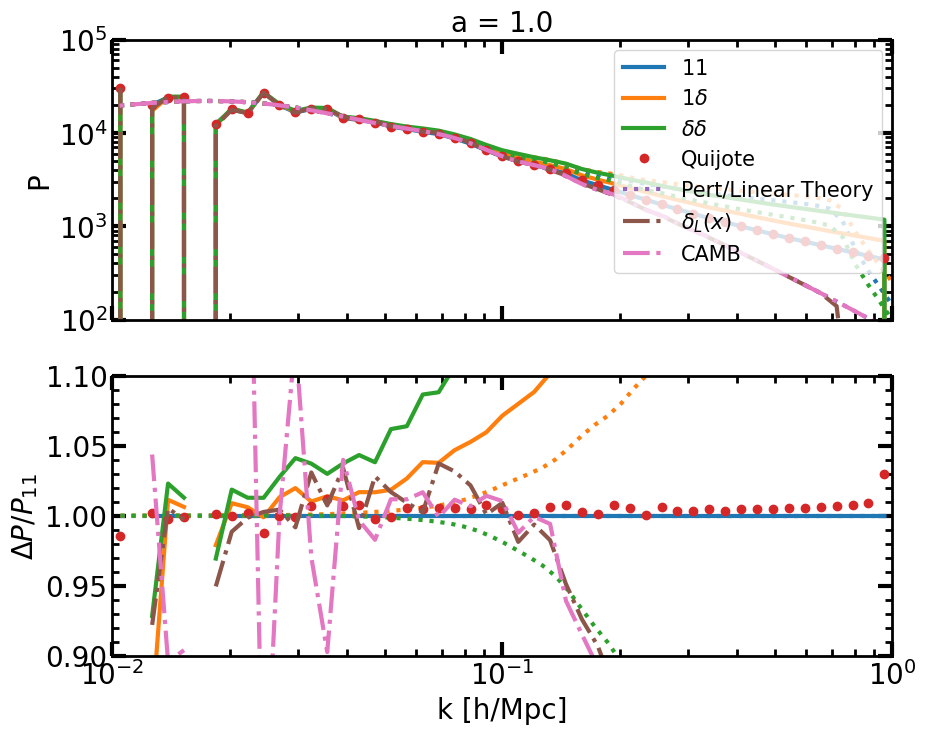

In [226]:
fig, ax = plt.subplots(2,1, figsize=(10,8), sharex=True)
ax[0].set_title("a = {0:.2}".format(sim.header["Time"]))

for i in [0,1,5]:
    c=ax[0].loglog(pk[i]['k'], pk[i]['pk'], label=labels_pt[i])
    ax[0].loglog(lt_k, pk_pt[i],ls=':', color=c[0].get_color())

    ax[1].semilogx(pk[i]['k'], pk[i]['pk']/pk[0]['pk'], label=labels_pt[i], c=c[0].get_color())
    ax[1].plot(lt_k, pk_pt[i]/pk_pt[0],ls=':', color=c[0].get_color())

c=ax[0].loglog(pksim['k'], pksim['pk'], 'o', label="Quijote")
ax[1].plot(pksim['k'], pksim['pk']/pk[0]['pk'], 'o', c=c[0].get_color())

ax[0].loglog(pk[i]['k'], sim.Cosmology.get_powerspec(pk[i]['k']), ls=':', label="Pert/Linear Theory")

c=ax[0].loglog(pk_delta['k'], pk_delta['pk']/ngrid**6, label='$\delta_L(x)$', ls="-.")
ax[1].plot(pk_delta['k'], pk_delta['pk']/ngrid**6/pk[0]['pk'], ls="-.", c=c[0].get_color())

kk, pk_camb = np.loadtxt("/dipc/reangulo/tmp/663/ICs/Pk_mm_z=0.000.txt", unpack=True)
pk_camb_i = np.exp(np.interp(np.log(pk_delta['k']), np.log(kk), np.log(pk_camb)))


c=ax[0].plot(kk, 0.855273*pk_camb, label="CAMB",ls="-.")
ax[1].plot(pk_delta['k'], 0.855273*pk_camb_i/pk[0]['pk'], ls="-.", c=c[0].get_color())

ax[1].set_xlabel("k [h/Mpc]")
ax[0].set_ylabel("P")
ax[1].set_ylabel("$\Delta P/P_{11}$")

ax[0].legend()
ax[1].set_ylim([0.9,1.1])
ax[0].set_ylim([1e2,1e5])
ax[0].set_xlim([1e-2,1])